# Test set scores for stocks with 5050 data points

In this notebook we present results for stocks with 5050 data points on test set for the choosen SVM models.

In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from lob_data_utils import roc_results
from lob_data_utils import lob
from lob_data_utils import db_result

data_length = 5050

## Data preparation

Data frame `df_cv` contains parameters and results from svm calculations for data length 5050 on validation set:

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$.
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1.
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 5050 data point data set
* `log_res` - result for logistic regression for 5050 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

In [2]:
results = db_result.get_svm_results_for_data_length(data_length, 'test')
result_cv = db_result.get_svm_results_for_data_length(data_length, 'cv')

df_cv = pd.DataFrame(result_cv)

In [3]:
df_cv.drop('algorithm_id', axis=1, inplace=True)
df_cv.drop('svm_id', axis=1, inplace=True)
df_cv.drop('name', axis=1, inplace=True)
df_cv.drop('id', axis=1, inplace=True)
df_cv.drop('data_length', axis=1, inplace=True)
df_cv.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock
0,0.0005,0.0,cv,0.005,rbf,0.5,10166
1,0.0005,0.0,cv,0.500,rbf,0.5,10166
2,0.0005,0.0,cv,5.000,rbf,0.5,10166
3,0.0005,0.0,cv,50.000,rbf,0.5,10166
4,0.0005,0.0,cv,500.000,rbf,0.5,10166


#### Description of `df_bests`

In this data set we aggregate calculations with the best score by stock. It has the same fields as `df_cv`.

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 5050 points dataset
* `log_res` - result for logistic regression for data with 5050 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

Additionally it has:

* `test_roc_auc_score` - roc area score for test set for the parameters `C`, `gamma` and `coef0` and `kernel`
* `test_log_roc_auc_score` - roc area score for test set for logistic regression

In [4]:
bests = []
df_best_agg = df_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']

test_roc_auc_scores = []
for i, row in df_bests.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests['test_roc_auc_score'] = test_roc_auc_scores 

In [5]:
log_res = []
for i, row in df_bests.iterrows():
    log_res.append(roc_results.result_test_5050.get(row['stock']))
df_bests['test_log_roc_auc_score'] = log_res
df_bests['diff'] = df_bests['test_roc_auc_score'] - log_res
df_bests.sort_values(by='roc_auc_score', inplace=True)
df_bests.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
stock,,,,,,,,,,
11867,10.000,0.0,cv,10.0,rbf,0.542120,11867,0.525106,0.534026,-0.008920
9063,0.005,5.0,cv,50.0,sigmoid,0.543825,9063,0.546798,0.518030,0.028768
9064,0.500,0.5,cv,5000.0,sigmoid,0.551678,9064,0.529613,0.540679,-0.011066
9062,1000.000,0.0,cv,1000.0,rbf,0.552284,9062,0.540273,0.548470,-0.008197
4549,0.500,0.0,cv,500.0,rbf,0.559443,4549,0.541380,0.550166,-0.008786


## Results for testing set

Below we present results comparing the best performing SVM on validation set against null hyposthesis and then to previous solution - logistic regression on testing set.

### SVM vs null hypothesis and validation set score

We compare best performing SVM models on validation set against null hypothesis using ROC area scores calculated on testing set.

We are always better than null-hypothesis - between 2-13%.

We can see that in most cases we perform worse on testing set than on validation set. The difference can be even 8%.

Testing - min:  0.520965926693 max: 0.631113938366
Validation - min:  0.542120424918 max: 0.641330875735


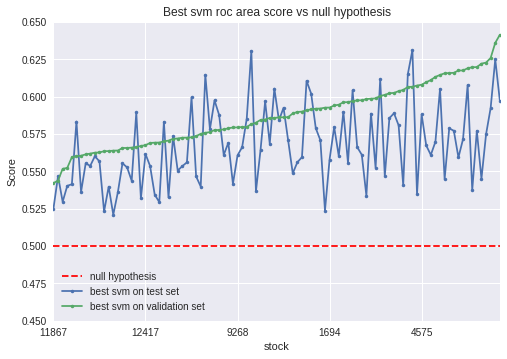

In [6]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
df_bests['roc_auc_score'].plot(marker='.', label='best svm on validation set')
print('Testing - min: ', df_bests['test_roc_auc_score'].min(), 'max:',  df_bests['test_roc_auc_score'].max())
print('Validation - min: ', df_bests['roc_auc_score'].min(), 'max:',  df_bests['roc_auc_score'].max())
plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs null hypothesis')

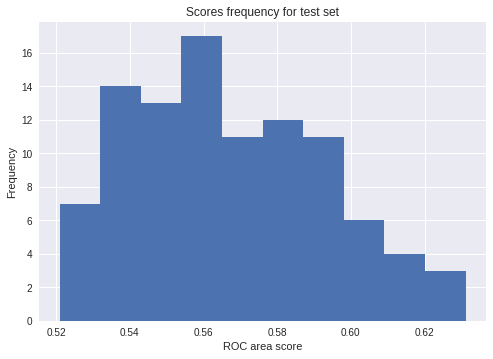

In [7]:
df_bests['test_roc_auc_score'].plot('hist')
plt.title('Scores frequency for test set')
plt.xlabel('ROC area score')

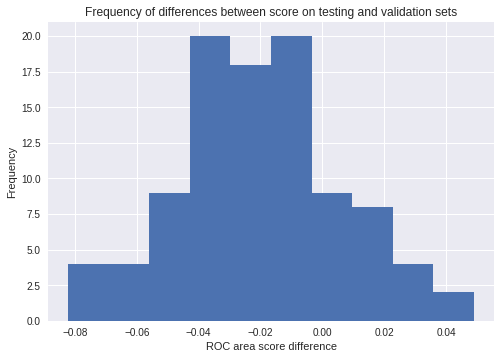

In [8]:
(df_bests['test_roc_auc_score'] - df_bests['roc_auc_score']).plot(kind='hist')
plt.title('Frequency of differences between score on testing and validation sets')
plt.xlabel('ROC area score difference')

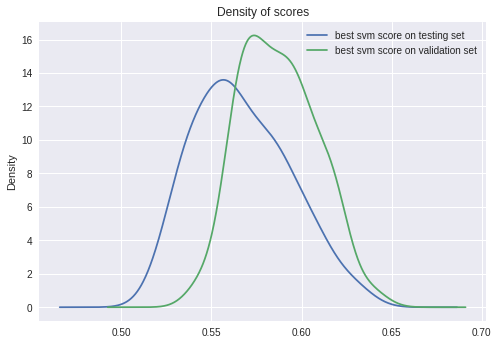

In [9]:
df_bests['test_roc_auc_score'].plot('kde', label='best svm score on testing set')
df_bests['roc_auc_score'].plot('kde', label='best svm score on validation set')
plt.title('Density of scores')
plt.legend()

### SVM vs logistic regression on testing set

In half of the cases we perform better than logistic regression. The difference varies between -3% and 4%.

In [10]:
print('Number of better SVMs:', 
      len(df_bests[df_bests['test_log_roc_auc_score'] < df_bests['test_roc_auc_score']]['stock'].unique()), 
      'per', len(df_bests['stock'].unique()))

Number of better SVMs: 40 per 98


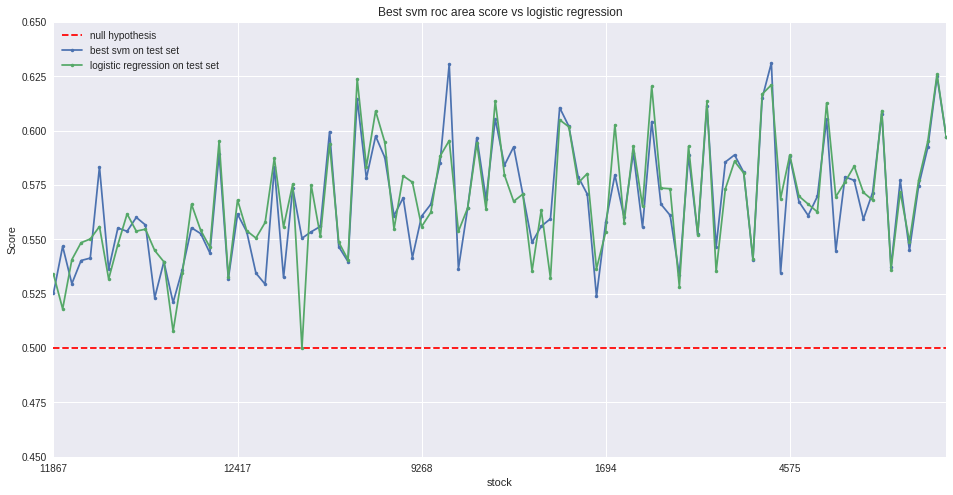

In [11]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set', figsize=(16, 8))
df_bests['test_log_roc_auc_score'].plot(marker='.', label='logistic regression on test set')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs logistic regression')

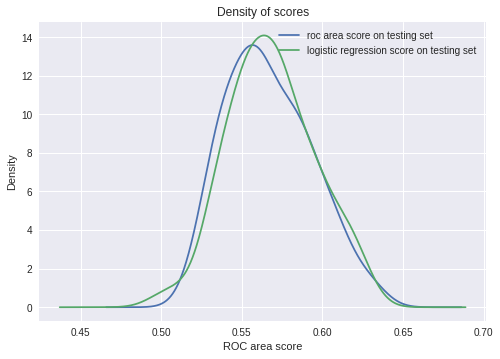

In [12]:
df_bests['test_roc_auc_score'].plot('kde', label='roc area score on testing set')
df_bests['test_log_roc_auc_score'].plot('kde', label='logistic regression score on testing set')
plt.title('Density of scores')
plt.xlabel('ROC area score')
plt.legend()

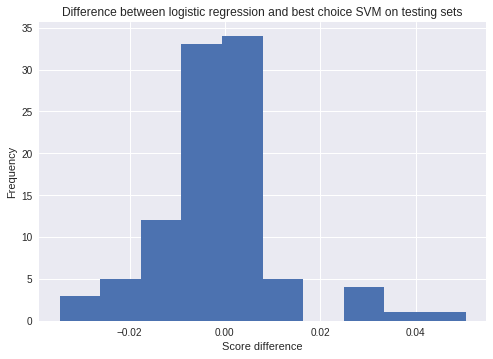

In [13]:
df_bests['diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM on testing sets')
plt.xlabel('Score difference')

## Results for testing by kernel

We choose the best performing model with linear, rbf and sigmoid kernel for each stock and compare them with null-hypothesis and logistic regression. 

We also compare how well they generalize using the scores from the same models on validation set.

To present results by kernel we prepare data frames:

* `df_bests_by_kernels` - aggregated results by kernel 
* `df_kernels_test` - ROC area score results (for testing set) for each stock for best performing on validation set
* `df_kernels_cv` - ROC area score results (for validation set) for each stock for best performing on validation set

In [14]:
df_best_agg = df_cv.groupby(['stock', 'kernel'], as_index=False)['roc_auc_score'].idxmax()
df_bests_by_kernels = df_cv.loc[df_best_agg]

test_roc_auc_scores = []
for i, row in df_bests_by_kernels.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests_by_kernels['test_roc_auc_score'] = test_roc_auc_scores 

In [15]:
log_res = []
for i, row in df_bests_by_kernels.iterrows():
    log_res.append(roc_results.result_test_5050.get(row['stock']))
df_bests_by_kernels['test_log_roc_auc_score'] = log_res
df_bests_by_kernels['diff'] = df_bests_by_kernels['test_roc_auc_score'] - log_res
df_bests_by_kernels.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
15,0.500,0.0,cv,-1.0,linear,0.547635,10166,0.553943,0.551324,0.002619
36446,100.000,0.0,cv,1.0,rbf,0.559713,10166,0.551204,0.551324,-0.000120
3634,0.500,0.5,cv,5000.0,sigmoid,0.572526,10166,0.555971,0.551324,0.004647
21855,0.005,0.0,cv,-1.0,linear,0.621270,10470,0.541373,0.548974,-0.007601
21865,5.000,0.0,cv,0.5,rbf,0.622024,10470,0.545011,0.548974,-0.003963


In [16]:
df_kernels_test = df_bests_by_kernels.pivot(index='stock', columns='kernel', values='test_roc_auc_score')
df_kernels_test.sort_index(inplace=True)
df_kernels_test.head()

df_kernels_val = df_bests_by_kernels.pivot(index='stock', columns='kernel', values='roc_auc_score')
df_kernels_val.sort_index(inplace=True)
df_kernels_val.head()

kernel,linear,rbf,sigmoid
stock,,,
10166,0.547635,0.559713,0.572526
10470,0.621270,0.622024,0.621270
10484,0.573921,0.573921,0.575059
10508,0.571979,0.586053,0.573617
10795,0.622213,0.625942,0.635927


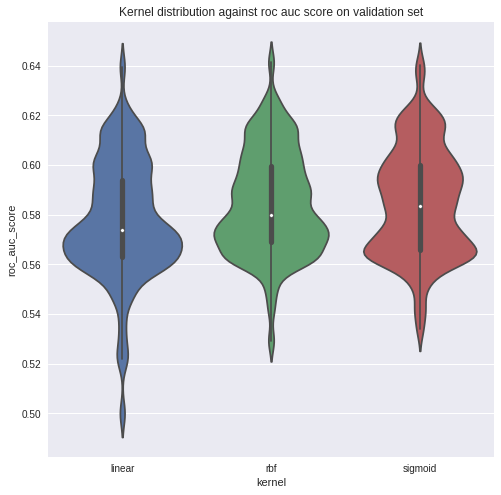

In [17]:
f, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(x='kernel', 
           y='roc_auc_score', data=df_bests_by_kernels, cut=2, bw=0.2)
sns.despine(left=True)
plt.title('Kernel distribution against roc auc score on validation set')

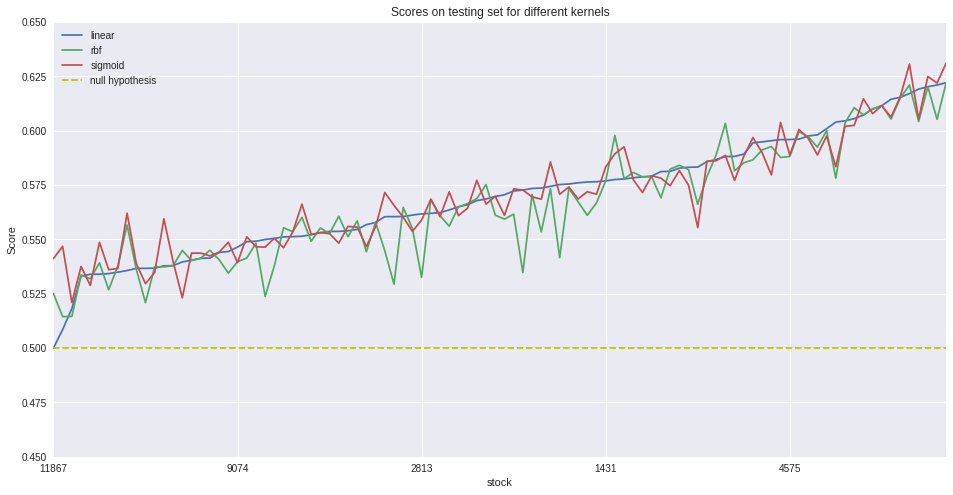

In [18]:
df_kernels_test.sort_values(by=['linear', 'sigmoid', 'rbf']).plot(figsize=(16, 8))
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')
plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Scores on testing set for different kernels')

There are less differences between kernels on testing set. We will check them separately in next sections.

### Linear kernel

For each stock we compare the ROC area score for the best performing SVM model with linear kernel on validation set computed on testing set against:

* null hypothesis ROC area score
* logistic regression ROC area score computed on testing set
* ROC area score on validation score for the same model

#### Linear kernel vs null hypothesis

We are always better - between 0%-12%.

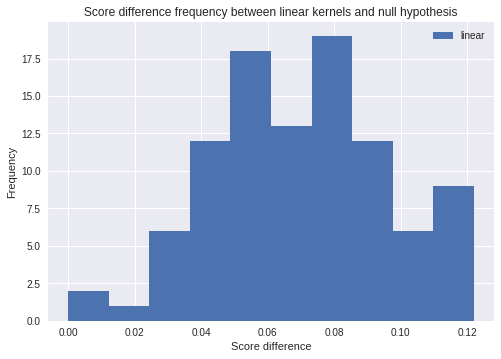

In [19]:
(df_kernels_test['linear'] - 0.5).plot(kind='hist')
plt.xlabel('Score difference')
plt.legend()
plt.title('Score difference frequency between linear kernels and null hypothesis')

#### Linear kernel vs logistic regression

It's hard to tell which one is better - linear kernel can be worse by 3% or better by even 4% - the most usually we are about the same.

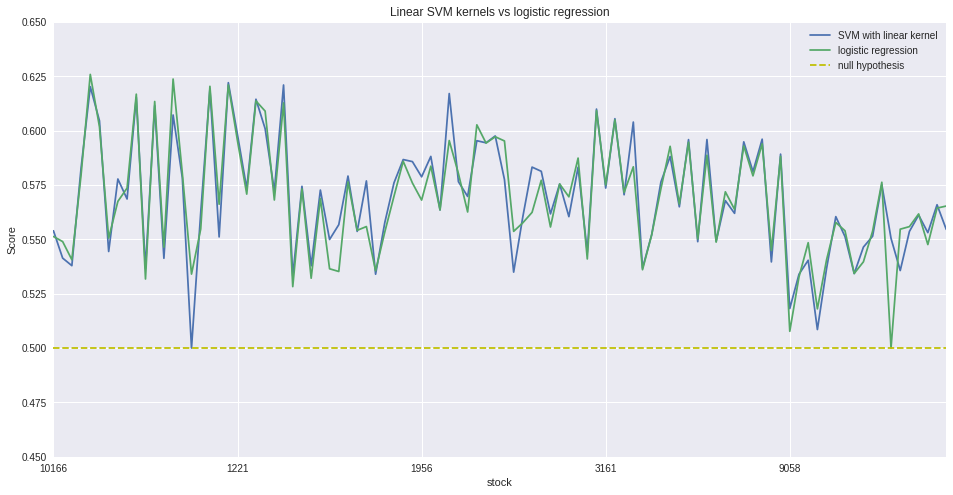

In [20]:
df_bests.sort_index(inplace=True)
df_kernels_test['linear'].plot(figsize=(16,8), label='SVM with linear kernel')
df_bests['test_log_roc_auc_score'].plot(label='logistic regression')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Linear SVM kernels vs logistic regression')

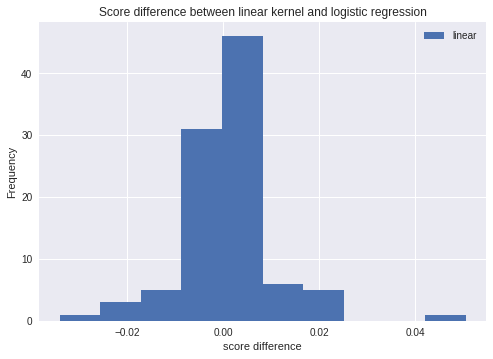

In [21]:
(df_kernels_test['linear'] - df_bests['test_log_roc_auc_score']).plot(kind='hist', label='linear')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between linear kernel and logistic regression on test')

#### Linear kernel on validation set vs linear kernel on testing set

SVM with linear kernel performs worse on testing set than on validation - max by 5%.

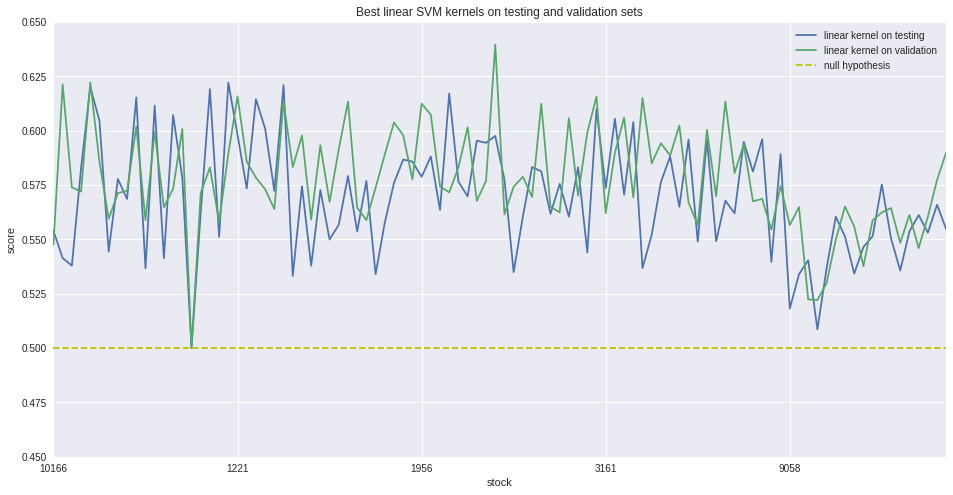

In [22]:
df_bests.sort_index(inplace=True)
df_kernels_test['linear'].plot(figsize=(16,8), label='linear kernel on testing')
df_kernels_val['linear'].plot(figsize=(16,8), label='linear kernel on validation')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best linear SVM kernels on testing and validation sets')

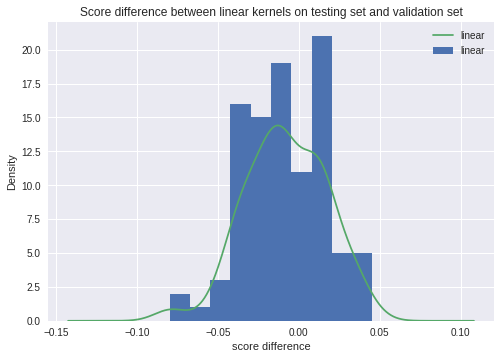

In [23]:
(df_kernels_test['linear'] - df_kernels_val['linear']).plot(kind='hist')
(df_kernels_test['linear'] - df_kernels_val['linear']).plot(kind='kde')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between linear kernels on testing set and validation set')

### RBF kernel

For each stock we compare the ROC area score for the best performing SVM model with rbf kernel on validation set computed on testing set against:

* null hypothesis ROC area score
* logistic regression ROC area score computed on testing set
* ROC area score on validation score for the same model

#### RBF kernel vs null hypothesis

We are always better - between 2-12%.

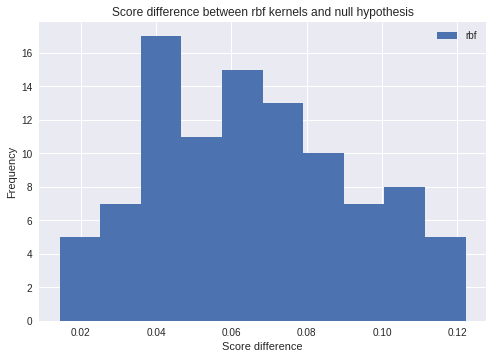

In [24]:
(df_kernels_test['rbf'] - 0.5).plot(kind='hist')
plt.xlabel('Score difference')
plt.legend()
plt.title('Score difference between rbf kernels and null hypothesis on test')

#### RBF kernel vs logistic regression

RBF kernel usually performs sometimes worse by -3%, sometimes better by even 4%.

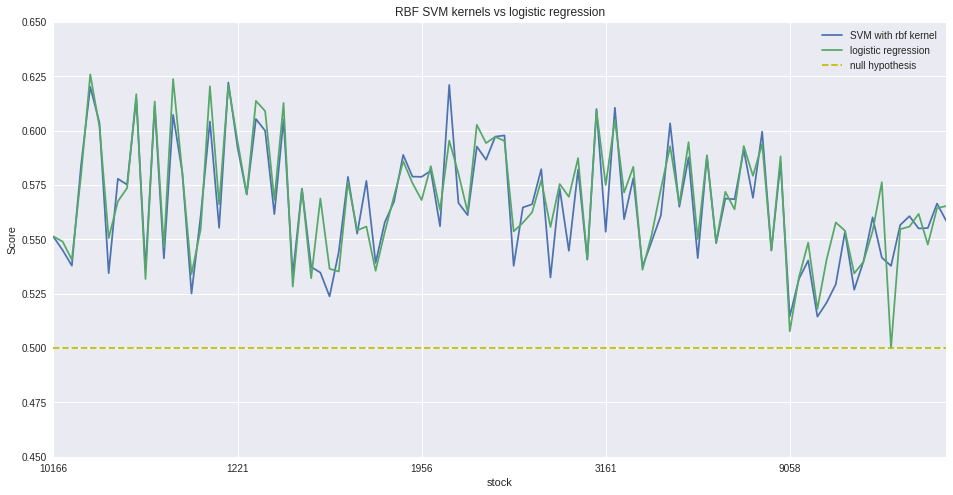

In [25]:
df_bests.sort_index(inplace=True)
df_kernels_test['rbf'].plot(figsize=(16,8), label='SVM with rbf kernel')
df_bests['test_log_roc_auc_score'].plot(label='logistic regression')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('RBF SVM kernels vs logistic regression')

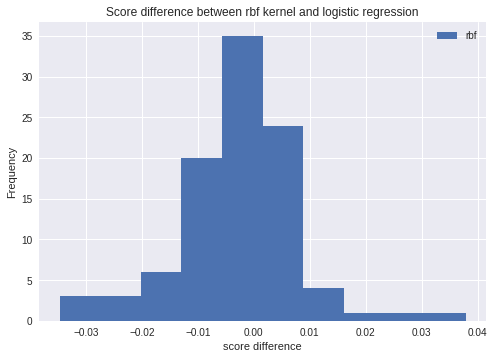

In [26]:
(df_kernels_test['rbf'] - df_bests['test_log_roc_auc_score']).plot(kind='hist', label='rbf')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between rbf kernel and logistic regression')

#### RBF kernel on validation set vs rbf kernel on testing set

SVM with rbf kernel can perform either better or worse by even 5 % on testing set than on validation set.

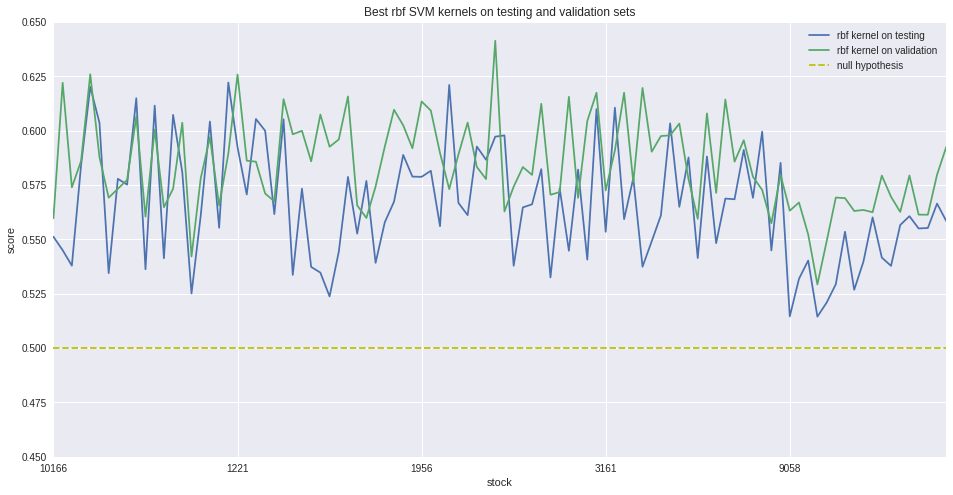

In [27]:
df_bests.sort_index(inplace=True)
df_kernels_test['rbf'].plot(figsize=(16,8), label='rbf kernel on testing')
df_kernels_val['rbf'].plot(figsize=(16,8), label='rbf kernel on validation')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best rbf SVM kernels on testing and validation sets')

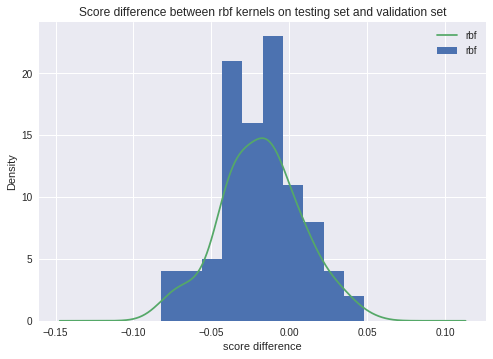

In [28]:
(df_kernels_test['rbf'] - df_kernels_val['rbf']).plot(kind='hist')
(df_kernels_test['rbf'] - df_kernels_val['rbf']).plot(kind='kde')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between rbf kernels on testing set and validation set')

### Sigmoid kernel

For each stock we compare the ROC area score for the best performing SVM model with sigmoid kernel on validation set computed on testing set against:

* null hypothesis ROC area score
* logistic regression ROC area score computed on testing set
* ROC area score on validation score for the same model

#### Sigmoid kernel vs null hypothesis

We are always better - between 2-13%.

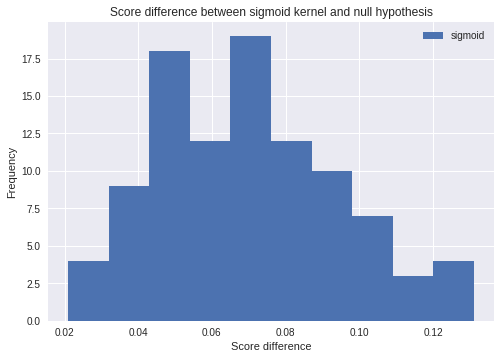

In [29]:
(df_kernels_test['sigmoid'] - 0.5).plot(kind='hist')
plt.xlabel('Score difference')
plt.legend()
plt.title('Score difference between sigmoid kernel and null hypothesis')

#### Sigmoid kernel vs logistic regression

Sigmoid kernel usually performs worse, in worst case by 2%. Rarely it performs better by 5%.

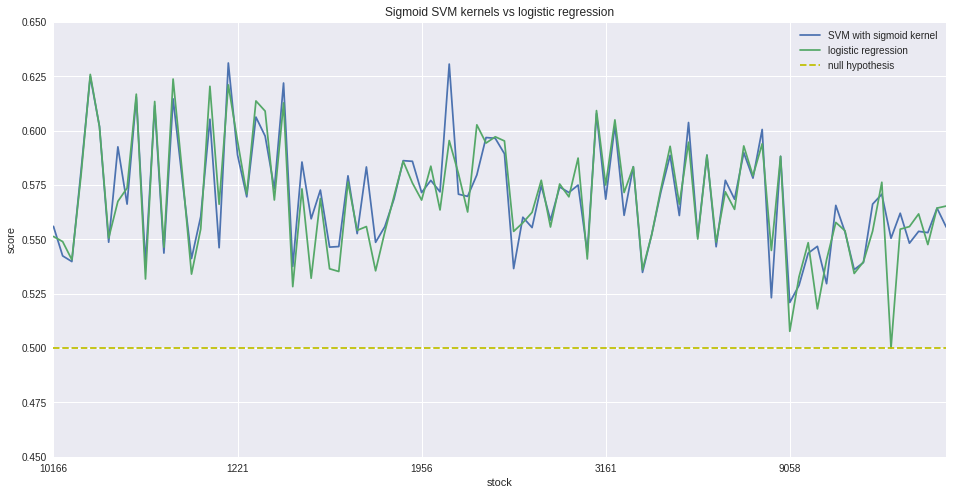

In [30]:
df_bests.sort_index(inplace=True)
df_kernels_test['sigmoid'].plot(figsize=(16,8), label='SVM with sigmoid kernel')
df_bests['test_log_roc_auc_score'].plot(label='logistic regression')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Sigmoid SVM kernels vs logistic regression')

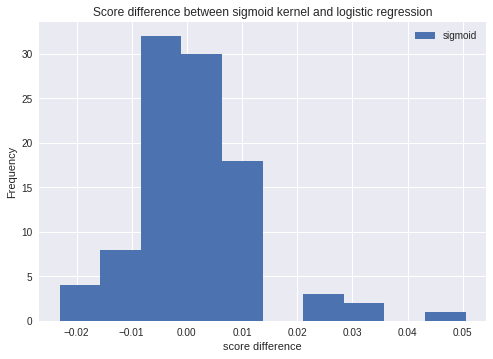

In [31]:
(df_kernels_test['sigmoid'] - df_bests['test_log_roc_auc_score']).plot(kind='hist', label='sigmoid')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between sigmoid kernel and logistic regression')

#### Sigmoid kernel on validation set vs sigmoid kernel on testing set

SVM with sigmoid kernel can perform either better or worse by 5% on testing set than on validation set, but more often the performance is worse.

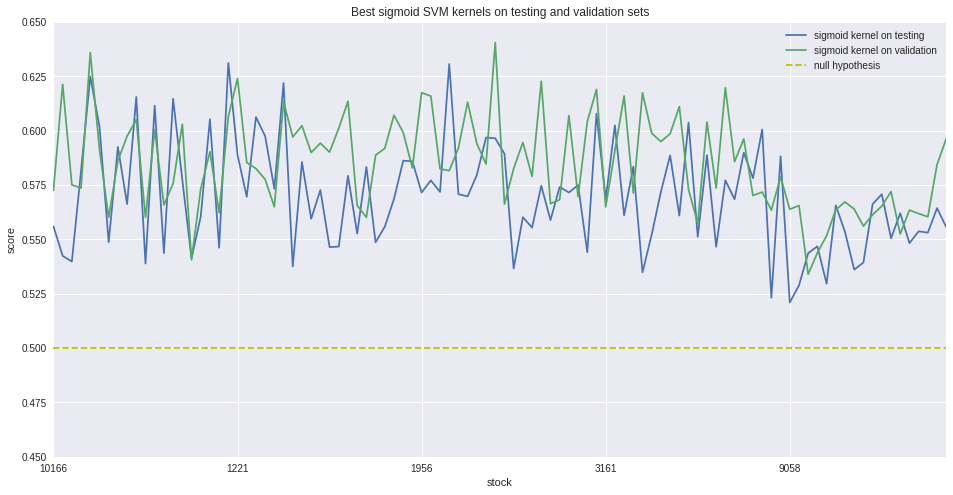

In [32]:
df_bests.sort_index(inplace=True)
df_kernels_test['sigmoid'].plot(figsize=(16,8), label='sigmoid kernel on testing')
df_kernels_val['sigmoid'].plot(figsize=(16,8), label='sigmoid kernel on validation')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best sigmoid SVM kernels on testing and validation sets')

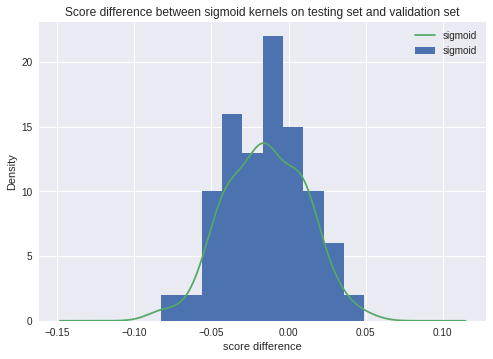

In [33]:
(df_kernels_test['sigmoid'] - df_kernels_val['sigmoid']).plot(kind='hist')
(df_kernels_test['sigmoid'] - df_kernels_val['sigmoid']).plot(kind='kde')
plt.xlabel('score difference')
plt.legend()
plt.title('Score difference between sigmoid kernels on testing set and validation set')

## Conclusions

* 5050 is too less data for SVM - it seems that logistic regression is a better model
* linear kernel has the most similar performance to logistic regression
* all kernels can be better than coin-toss